<a href="https://colab.research.google.com/github/EdisonMaxwell/udacity_mlnd_capstone/blob/master/3_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying urban sounds using deep learning models.
## Model Training and Evaluation
### Load preprocessed data

The data is loaded from a .npz file that contains prepocessed data that was previously created along with ordered array containing class names.
After that the data is split into training and testing sets. The amount of data is low so the splits cannot be large.

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
#installing a fork of tqdm for keras
!pip install --upgrade keras-tqdm
!pip install --upgrade tqdm

Requirement already up-to-date: keras-tqdm in /usr/local/lib/python3.6/dist-packages (2.0.1)
Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.42.1)


In [0]:
# Retrieve contents of the data file.
import numpy as np
from tqdm.notebook import tqdm

BASE_PATH = '/content/drive/My Drive/mlnd_data'
file_path = BASE_PATH+'/dataset.npz'
contents = np.load(file_path, allow_pickle=True)

X = contents['features']
y = contents['labels']
classes = contents['classes']

In [0]:
%tensorflow_version 2.x

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,shuffle=True)
#from SpectralDataGenerator import SpectralDataGenerator as gen
#train_gen = gen(audio = X_train, labels = y_train, batch_size = batch_size, dim = (width,height), channels = channels, noise_factor = 0.3)
#val_gen = gen(audio = X_val, labels = y_val, batch_size = 128, dim = (width,height), channels = channels, noise_factor = 0.3)

### Convolutional Neural Network model architecture
CNNs are some of the best tools for image classification do to their ability to quantify spatial relationships. 
Our architecture will be a relatively small `Sequential`model consisting of 3 `Conv2D`convolution layers each followed by a `MaxPooling2D` pooling layer. Finally, the output is from a `Dense` layer connected to the Convolutional.
    
The convolutional layer perform the actual feature selection. It slides a small window(aka kernel or filter) with weights on it over the pixels of the image. It starts at the top and performs summation matrix operations and saves the result as part of an activation map. This process is called convolution. The filter parameter specifies the number of filters that will be applied to a layer in the CNN. Each layer of a CNN can have many filters. Each filter learns something differnt about the problem statment and crosses the activation threshold for different inputs.

The pooling layers reduce dimensionality wihout much loss in data. This increases robustness of the model and lowers its compute and storage requirements. Two type of pooling layers will be used in the model. Firstly, `MaxPooling2D` will be used between Convolutional layers to reduce dimensionality while preserving spatial information. 

After features are extracted, they are fed into a `GlobalAveragePooling2D` layer to flatten the features into a vector while preserving more information than simply flattening it with the `Flatten` layer.

The output layer will have 10 nodes which matches the number of target classes. The `Softmax` activation function will used on the output layer giving us a vector of probabilities.

In [0]:
%tensorflow_version 2.x

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

width = 40
height = 175
channels = 1
batch_size = 256

X_train = X_train.reshape(X_train.shape[0],width,height,channels)
X_test = X_test.reshape(X_test.shape[0],width,height,channels)

label_count = y.shape[1]

model = Sequential([
    Conv2D(filters=16,kernel_size=2,input_shape=(width,height,channels),activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=2), 
      
    Conv2D(filters=32,kernel_size=2,activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=2), 
    
    Conv2D(filters=64,kernel_size=2,activation='relu'),
    Dropout(0.2),
    GlobalAveragePooling2D(),
    
    Dense(units=128,activation='tanh'),
    Dropout(0.1),
    Dense(units=label_count,activation='softmax')  
])

model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

### Model Compilation

In [45]:
# Model architecture
model.summary()

#pretraining_accuracy
#score = model.evaluate(X_test,y_test,verbose=1)
#accuracy = 100*score[1]

#print('Pretraining accuracy:%.4f%%' % accuracy)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 39, 174, 16)       80        
_________________________________________________________________
dropout_8 (Dropout)          (None, 39, 174, 16)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 19, 87, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 86, 32)        2080      
_________________________________________________________________
dropout_9 (Dropout)          (None, 18, 86, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 43, 32)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 42, 64)        

### Training

The training of the model begins. CNNs are best trained on the GPU because of their high parallelization capability. One can train lower epoch numbers on the CPU but its a waste of time and energy regardless.

In [46]:
%%timeit

from keras_tqdm import TQDMNotebookCallback
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, History,TensorBoard
from tensorflow.keras.optimizers import Adam
from datetime import datetime
import os

now = datetime.now()

#learning rate reduction
MAX_PATIENCE = 2

best_filepath = BASE_PATH+'/best_model.hdf5'

#callbacks
callback = [ReduceLROnPlateau(patience = MAX_PATIENCE, verbose = 0),
            ModelCheckpoint(filepath=best_filepath,monitor='val_loss',verbose=0,save_best_only=True),
            TQDMNotebookCallback(leave_outer=None,leave_inner=None)]

#compile
model.compile(optimizer=Adam(learning_rate=0.01),loss='categorical_crossentropy',metrics=['accuracy'])

#train
model.fit(x=X_train,
          y=y_train,
          epochs=75,
          batch_size=batch_size,
          verbose=0,
          validation_split = 0.3,
          shuffle=True,
          callbacks=callback)


1 loop, best of 3: 46.9 s per loop


### Testing the model
We will use the small testing dataset we set aside to calulate the model's performance.

In [47]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.90977347
Testing Accuracy:  0.895881


The model performs well, though the difference between the training and testing scores can indicate overfitting. This can be mitigated by augmenting the audio data before extraction of MFCCs by adding noise, distortion, pitch shifts and other random manipulation of sound.

### Making Predictions
We shall make predictions on data sourced from the outside world or online.

In [0]:
import librosa 
from sklearn.preprocessing import LabelEncoder

def get_mfccs(file_path,offset):
    max_pad_len=175

    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast',offset=offset,duration=4.0) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print(e,file_path)
        return None 
     
    return mfccs

def print_prediction(file_path,offset):
    prediction_feature = get_mfccs(file_path,offset) 
    prediction_feature = prediction_feature.reshape(1, width, height, channels)

    prediction_vector = model.predict(prediction_feature)
    predicted_class = np.argmax(prediction_vector)
    print("Prediction: ",classes[predicted_class])

    #predicted_proba_vector = model.predict_proba(prediction_feature) 
    #predicted_proba = predicted_proba_vector[0]
    #for i in range(len(predicted_proba)): 
     #   category = le.inverse_transform(np.array([i]))
      #  print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )


## Air Conditioner

In [49]:
%%time
audio_dir = BASE_PATH+'/sample_sounds/'
file_path = audio_dir+'air-conditioner-on-a-camping-place.wav'
print_prediction(file_path,45)

Prediction:  engine_idling
CPU times: user 179 ms, sys: 159 ms, total: 339 ms
Wall time: 400 ms


## Drilling

In [50]:
%%time
audio_dir = BASE_PATH+'/sample_sounds/'
file_path = audio_dir+'road-drilling-and-noise.wav'
print_prediction(file_path,0)

Prediction:  drilling
CPU times: user 85.2 ms, sys: 112 ms, total: 197 ms
Wall time: 335 ms


## Street Music

In [51]:
%%time
audio_dir = BASE_PATH+'/sample_sounds/'
file_path = audio_dir+'street-music.wav'
print_prediction(file_path,2)

Prediction:  street_music
CPU times: user 103 ms, sys: 106 ms, total: 209 ms
Wall time: 561 ms


## Gunshot


In [52]:
%%time
#InspectorJ (www.jshaw.co.uk) of Freesound.org
audio_dir = BASE_PATH+'/sample_sounds/'
file_path = audio_dir+'gunshot-distant-a.wav'
print_prediction(file_path,0)

Prediction:  dog_bark
CPU times: user 99.7 ms, sys: 101 ms, total: 200 ms
Wall time: 452 ms


## Car Horn

In [53]:
%%time
audio_dir = BASE_PATH+'/sample_sounds/'
file_path = audio_dir+'car-very-long-mini-countryman.wav'
print_prediction(file_path,0)

Prediction:  drilling
CPU times: user 78 ms, sys: 115 ms, total: 193 ms
Wall time: 303 ms


## Dog Barking

In [54]:
%%time
#InspectorJ (www.jshaw.co.uk) of Freesound.org
audio_dir = BASE_PATH+'/sample_sounds/'
file_path = audio_dir+'dog-barking-single-a.wav'
print_prediction(file_path,1)

Prediction:  dog_bark
CPU times: user 102 ms, sys: 99.8 ms, total: 202 ms
Wall time: 619 ms


## Jackhammer

In [55]:
%%time
audio_dir = BASE_PATH+'/sample_sounds/'
file_path = audio_dir+'jackhammer.wav'
print_prediction(file_path,1)

Prediction:  jackhammer
CPU times: user 103 ms, sys: 148 ms, total: 251 ms
Wall time: 781 ms


In [0]:
predictions = model.predict(X_test)
y_pred = classes[predictions.argmax(axis=1)]
y_test_1= classes[y_test.argmax(axis=1)]

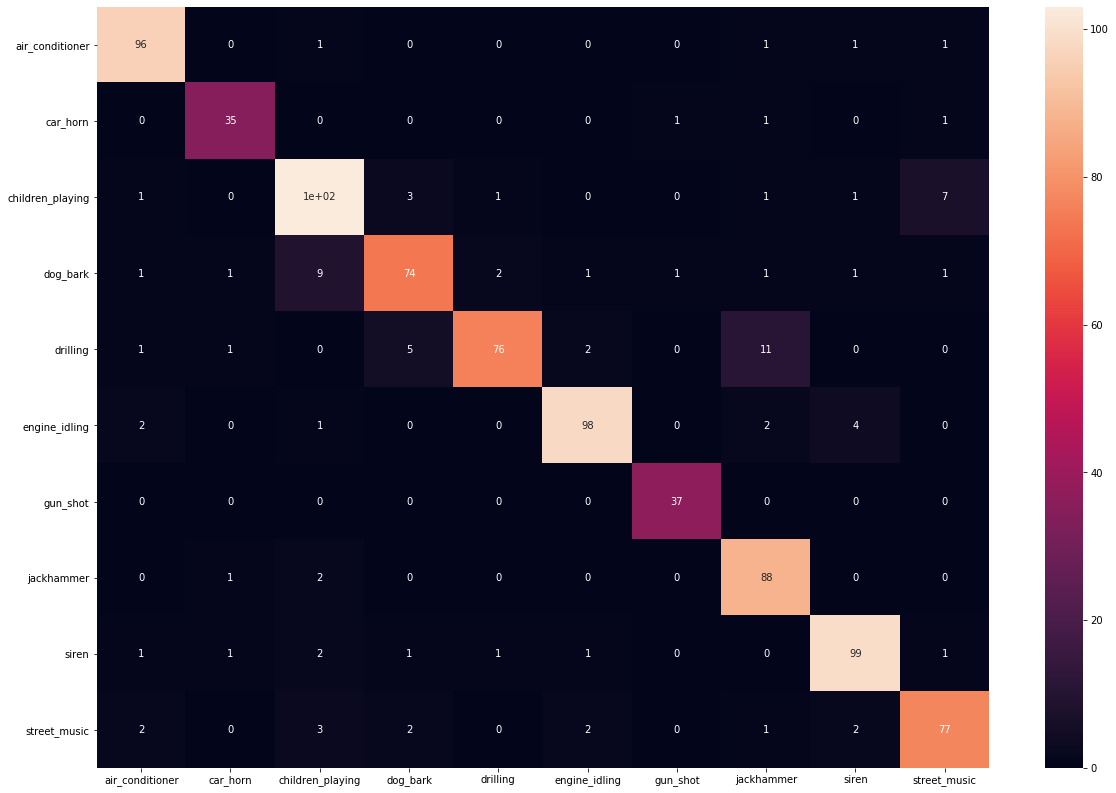

In [109]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test_1,y_pred,labels=classes)
matrix_df = pd.DataFrame(matrix,index=classes,columns=classes)
plt.figure(figsize=(20,14))
sn.heatmap(matrix_df,annot=True)

## Observations

The model performed well on real world examples recorded with different types of hardware. I was pleasantly surprised when it was able to distinguish between drilling and a jackhammer.

I am not surprised at the fact that the model could not differentiate between an idling vehicle and an air conditioner or a gunshot and barking dogs. Those two were hard to differentiate due to similar sounds. I am confused about the car horn being confused as drilling noise. I have not been able to rectify any of these errors. I could be argued, however, that these real-world noises may need more processing before being fed to the model or that the training data needs to be augmented. I had experimented with adding random noise to the sounds before conversion to MFCCs and it resulted in a poorly performing model.